
# 第九章 推荐系统简介


![image.png](images/recsys.png)

## 集体智慧编程

> 集体智慧是指为了创造新想法，将一群人的行为、偏好或思想组合在一起。一般基于聪明的算法（Netflix, Google）或者提供内容的用户(Wikipedia)。

集体智慧编程所强调的是前者，即通过编写计算机程序、构造具有智能的算法收集并分析用户的数据，发现新的信息甚至是知识。

Toby Segaran, 2007, Programming Collective Intelligence. O'Reilly. 

https://github.com/computational-class/programming-collective-intelligence-code/blob/master/chapter2/recommendations.py

## 推荐系统

- 目前互联网世界最常见的智能产品形式。
- 从信息时代过渡到注意力时代：
    - 信息过载（information overload）
    - 注意力稀缺
- 推荐系统的基本任务是联系用户和物品，帮助用户快速发现有用信息，解决信息过载的问题。
    - 针对长尾分布问题，找到个性化需求，优化资源配置



## 推荐系统的类型
- 基于流行度的推荐
- 社会化推荐（Social Recommendation）
    - 让朋友帮助推荐物品
- 基于内容的推荐 （Content-based filtering）
    - 基于用户已经消费的物品内容，推荐新的物品。例如根据看过的电影的导演和演员，推荐新影片。
- 基于协同过滤的推荐（collaborative filtering）
    - 找到和某用户的历史兴趣一致的用户，根据这些用户之间的相似性或者他们所消费物品的相似性，为该用户推荐物品
- 隐语义模型（latent factor model）
- 基于图的随机游走算法（random walk on graphs）

## 协同过滤算法

- 基于邻域的方法（neighborhood-based method）
    - 基于用户的协同过滤（user-based filtering）
    - 基于物品的协同过滤 （item-based filtering）


## UserCF和ItemCF的比较

- UserCF较为古老， 1992年应用于电子邮件个性化推荐系统Tapestry, 1994年应用于Grouplens新闻个性化推荐， 后来被Digg采用
    - 推荐那些与个体有共同兴趣爱好的用户所喜欢的物品（群体热点，社会化）
        - 反映用户所在小型群体中物品的热门程度
- ItemCF相对较新，应用于电子商务网站Amazon和DVD租赁网站Netflix
    - 推荐那些和用户之前喜欢的物品相似的物品 （历史兴趣，个性化）
        - 反映了用户自己的兴趣传承
- 新闻更新快，物品数量庞大，相似度变化很快，不利于维护一张物品相似度的表格，电影、音乐、图书则可以。



## 推荐系统评测
- 用户满意度
- 预测准确度

    $r_{ui}$用户实际打分， $\hat{r_{ui}}$推荐算法预测打分, T为测量次数

    - 均方根误差RMSE
    
        $RMSE = \sqrt{\frac{\sum_{u, i \in T} (r_{ui} - \hat{r_{ui}})}{ T }^2} $
        
    - 平均绝对误差MAE
    
        $  MAE = \frac{\sum_{u, i \in T} \left | r_{ui} - \hat{r_{ui}} \right|}{ T}$

In [1]:
# A dictionary of movie critics and their ratings of a small
# set of movies
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
      'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
      'The Night Listener': 3.0},
     'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
      'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
      'You, Me and Dupree': 3.5},
     'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
      'Superman Returns': 3.5, 'The Night Listener': 4.0},
     'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
      'The Night Listener': 4.5, 'Superman Returns': 4.0,
      'You, Me and Dupree': 2.5},
     'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
      'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
      'You, Me and Dupree': 2.0},
     'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
      'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
     'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

In [3]:
critics['Lisa Rose']['Lady in the Water']

2.5

In [4]:
critics['Toby']['Snakes on a Plane']

4.5

In [5]:
critics['Toby']

{'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}


## 1. User-based filtering


### 1.0 Finding similar users

In [6]:
# 欧几里得距离
import numpy as np
np.sqrt(np.power(5-4, 2) + np.power(4-1, 2))

3.1622776601683795

- This formula calculates the distance, which will be smaller for people who are more similar. 
- However, you need a function that gives higher values for people who are similar. 
- This can be done by adding 1 to the function (so you don’t get a division-by-zero error) and inverting it:

In [7]:
1.0 /(1 + np.sqrt(np.power(5-4, 2) + np.power(4-1, 2)) )

0.2402530733520421

In [8]:
# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs,person1,person2):
    # Get the list of shared_items
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
    # if they have no ratings in common, return 0
    if len(si)==0: return 0
    # Add up the squares of all the differences
    sum_of_squares=np.sum([np.power(prefs[person1][item]-prefs[person2][item],2) for item in si])
    return 1/(1+np.sqrt(sum_of_squares) )

In [9]:
sim_distance(critics, 'Lisa Rose','Toby')

0.3483314773547883

### Pearson Correlation Coefficient

In [10]:
# Returns the Pearson correlation coefficient for p1 and p2
def sim_pearson(prefs,p1,p2):
    # Get the list of mutually rated items
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1
    # Find the number of elements
    n=len(si)
    # if they are no ratings in common, return 0
    if n==0: return 0
    # Add up all the preferences
    sum1=np.sum([prefs[p1][it] for it in si])
    sum2=np.sum([prefs[p2][it] for it in si])
    # Sum up the squares
    sum1Sq=np.sum([np.power(prefs[p1][it],2) for it in si])
    sum2Sq=np.sum([np.power(prefs[p2][it],2) for it in si])
    # Sum up the products
    pSum=np.sum([prefs[p1][it]*prefs[p2][it] for it in si])
    # Calculate Pearson score
    num=pSum-(sum1*sum2/n)
    den=np.sqrt((sum1Sq-np.power(sum1,2)/n)*(sum2Sq-np.power(sum2,2)/n))
    if den==0: return 0
    return num/den

In [22]:
sim_pearson(critics, 'Lisa Rose','Toby')


0.9912407071619299

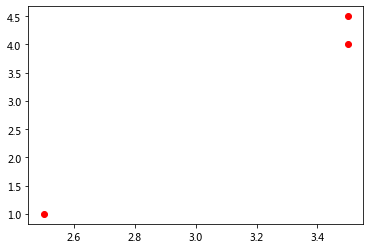

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
si = [item for item in critics['Lisa Rose'] if item in critics['Toby']]
score1 = [critics['Lisa Rose'][i] for i in si]
score2 = [critics['Toby'][i] for i in si]

plt.plot(score1, score2, 'ro');

In [23]:
# Returns the best matches for person from the prefs dictionary.
# Number of results and similarity function are optional params.
def topMatches(prefs,person,n=5,similarity=sim_pearson):
    scores=[(similarity(prefs,person,other),other)
        for other in prefs if other!=person]
    # Sort the list so the highest scores appear at the top 
    scores.sort( )
    scores.reverse( )
    return scores[0:n]

In [24]:
topMatches(critics,'Toby',n=3) # topN

[(0.9912407071619299, 'Lisa Rose'),
 (0.9244734516419049, 'Mick LaSalle'),
 (0.8934051474415647, 'Claudia Puig')]

## 1.1 Recommending Items

<img src="images/recsys2.png" width =1000>

 Toby相似的五个用户（Rose, Reymour, Puig, LaSalle, Matthews）及相似度（依次为0.99， 0.38， 0.89， 0.92, 0.66）
- 这五个用户看过的三个电影（Night,Lady, Luck）及其评分
    - 例如，Rose对Night评分是3.0
- S.xNight是用户相似度与电影评分的乘积
    - 例如，Toby与Rose相似度(0.99) * Rose对Night评分是3.0 = 2.97
- 可以得到每部电影的得分
    - 例如，Night的得分是12.89 = 2.97+1.14+4.02+2.77+1.99
- 电影得分需要使用用户相似度之和进行加权
    - 例如，Night电影的预测得分是3.35 = 12.89/3.84


In [25]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommendations(prefs,person,similarity=sim_pearson):
    totals={}
    simSums={}
    for other in prefs:
        # don't compare me to myself
        if other==person: continue
        sim=similarity(prefs,person,other)
        # ignore scores of zero or lower
        if sim<=0: continue
        for item in prefs[other]:   
            # only score movies I haven't seen yet
            if item not in prefs[person]:# or prefs[person][item]==0:
                # Similarity * Score
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
                # Sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+=sim
    # Create the normalized list
    rankings=[(total/simSums[item],item) for item,total in totals.items()]
    # Return the sorted list
    rankings.sort()
    rankings.reverse()
    return rankings

In [27]:
# Now you can find out what movies I should watch next:
getRecommendations(critics,'Toby')

[(3.3477895267131017, 'The Night Listener'),
 (2.8325499182641614, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

In [28]:
# You’ll find that the results are only affected very slightly by the choice of similarity metric.
getRecommendations(critics,'Toby',similarity=sim_distance)

[(3.457128694491423, 'The Night Listener'),
 (2.778584003814924, 'Lady in the Water'),
 (2.422482042361917, 'Just My Luck')]


## 2. Item-based filtering


Now you know how to find similar people and recommend products for a given person

**But what if you want to see which products are similar to each other?**

This is actually the same method we used earlier to determine similarity between people—

### 将item-user字典的键值翻转

In [29]:
# you just need to swap the people and the items. 
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})
            # Flip item and person
            result[item][person]=prefs[person][item]
    return result

movies = transformPrefs(critics)


### 计算item的相似性

In [30]:
topMatches(movies,'Superman Returns')

[(0.6579516949597695, 'You, Me and Dupree'),
 (0.4879500364742689, 'Lady in the Water'),
 (0.11180339887498941, 'Snakes on a Plane'),
 (-0.1798471947990544, 'The Night Listener'),
 (-0.42289003161103106, 'Just My Luck')]

### 给item推荐user

In [31]:
def calculateSimilarItems(prefs,n=10):
    # Create a dictionary of items showing which other items they
    # are most similar to.
    result={}
    # Invert the preference matrix to be item-centric
    itemPrefs=transformPrefs(prefs)
    c=0
    for item in itemPrefs:
        # Status updates for large datasets
        c+=1
        if c%100==0: 
            print("%d / %d" % (c,len(itemPrefs)))
        # Find the most similar items to this one
        scores=topMatches(itemPrefs,item,n=n,similarity=sim_distance)
        result[item]=scores
    return result

itemsim=calculateSimilarItems(critics) 
itemsim['Superman Returns']

[(0.3090169943749474, 'Snakes on a Plane'),
 (0.252650308587072, 'The Night Listener'),
 (0.2402530733520421, 'Lady in the Water'),
 (0.20799159651347807, 'Just My Luck'),
 (0.1918253663634734, 'You, Me and Dupree')]

<img src="images/recsys3.png" width = 1200>

Toby看过三个电影（snakes、Superman、dupree）和评分（依次是4.5、4.0、1.0）
- 表格2-3给出这三部电影与另外三部电影的相似度
    - 例如superman与night的相似度是0.103
- R.xNight表示Toby对自己看过的三部定影的评分与Night这部电影相似度的乘积
    - 例如，0.818 = 4.5*0.182
    
    
- 那么Toby对于Night的评分可以表达为0.818+0.412+0.148 = 1.378
    - 已经知道Night相似度之和是0.182+0.103+0.148 = 0.433
        - 那么Toby对Night的最终评分可以表达为：1.378/0.433 = 3.183


In [32]:
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}
    # Loop over items rated by this user
    for (item,rating) in userRatings.items( ):
        # Loop over items similar to this one
        for (similarity,item2) in itemMatch[item]:
            # Ignore if this user has already rated this item
            if item2 in userRatings: continue
            # Weighted sum of rating times similarity
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
            # Sum of all the similarities
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity
    # Divide each total score by total weighting to get an average
    rankings=[(score/totalSim[item],item) for item,score in scores.items( )]
    # Return the rankings from highest to lowest
    rankings.sort( )
    rankings.reverse( )
    return rankings

getRecommendedItems(critics,itemsim,'Toby')

[(3.1667425234070894, 'The Night Listener'),
 (2.9366294028444346, 'Just My Luck'),
 (2.868767392626467, 'Lady in the Water')]

In [33]:
getRecommendations(movies,'Just My Luck')

[(4.0, 'Michael Phillips'), (3.0, 'Jack Matthews')]

In [34]:
getRecommendations(movies, 'You, Me and Dupree')

[(3.1637361366111816, 'Michael Phillips')]

<img src = './img/itemcfNetwork.png' width = 700px>

**基于物品的协同过滤算法的网络表示方法**

## 基于图的模型

使用二分图表示用户行为，因此基于图的算法可以应用到推荐系统当中。

<img src = './img/graphrec.png' width = 500px>

In [35]:
# https://github.com/ParticleWave/RecommendationSystemStudy/blob/d1960056b96cfaad62afbfe39225ff680240d37e/PersonalRank.py
import os
import random

class Graph:
    def __init__(self):
        self.G = dict()
    
    def addEdge(self, p, q):
        if p not in self.G: self.G[p] = dict()
        if q not in self.G: self.G[q] = dict()
        self.G[p][q] = 1
        self.G[q][p] = 1

    def getGraphMatrix(self):
        return self.G

In [36]:
graph = Graph()
graph.addEdge('A', 'a')
graph.addEdge('A', 'c')
graph.addEdge('B', 'a')
graph.addEdge('B', 'b')
graph.addEdge('B', 'c')
graph.addEdge('B', 'd')
graph.addEdge('C', 'c')
graph.addEdge('C', 'd')
G = graph.getGraphMatrix()
print(G.keys())

dict_keys(['A', 'a', 'c', 'B', 'b', 'd', 'C'])


In [37]:
G

{'A': {'a': 1, 'c': 1},
 'a': {'A': 1, 'B': 1},
 'c': {'A': 1, 'B': 1, 'C': 1},
 'B': {'a': 1, 'b': 1, 'c': 1, 'd': 1},
 'b': {'B': 1},
 'd': {'B': 1, 'C': 1},
 'C': {'c': 1, 'd': 1}}

In [38]:
for i, ri in G.items():
    for j, wij in ri.items():
        print(i, j, wij) 

A a 1
A c 1
a A 1
a B 1
c A 1
c B 1
c C 1
B a 1
B b 1
B c 1
B d 1
b B 1
d B 1
d C 1
C c 1
C d 1


In [39]:
def PersonalRank(G, alpha, root, max_step):
    # G is the biparitite graph of users' ratings on items
    # alpha is the probability of random walk forward
    # root is the studied User
    # max_step if the steps of iterations.
    rank = dict()
    rank = {x:0.0 for x in G.keys()}
    rank[root] = 1.0
    for k in range(max_step):
        tmp = {x:0.0 for x in G.keys()}
        for i,ri in G.items():
            for j,wij in ri.items():
                if j not in tmp: tmp[j] = 0.0 #
                tmp[j] += alpha * rank[i] / (len(ri)*1.0)
                if j == root: tmp[j] += 1.0 - alpha
        rank = tmp
        print(k, rank)
    return rank

In [40]:
PersonalRank(G, 0.8, 'A', 20)
#    print(PersonalRank(G, 0.8, 'B', 20))
#    print(PersonalRank(G, 0.8, 'C', 20))

0 {'A': 0.3999999999999999, 'a': 0.4, 'c': 0.4, 'B': 0.0, 'b': 0.0, 'd': 0.0, 'C': 0.0}
1 {'A': 0.6666666666666666, 'a': 0.15999999999999998, 'c': 0.15999999999999998, 'B': 0.2666666666666667, 'b': 0.0, 'd': 0.0, 'C': 0.10666666666666669}
2 {'A': 0.5066666666666666, 'a': 0.32, 'c': 0.3626666666666667, 'B': 0.10666666666666665, 'b': 0.053333333333333344, 'd': 0.09600000000000003, 'C': 0.04266666666666666}
3 {'A': 0.624711111111111, 'a': 0.22399999999999998, 'c': 0.24106666666666665, 'B': 0.3057777777777778, 'b': 0.02133333333333333, 'd': 0.03839999999999999, 'C': 0.13511111111111113}
4 {'A': 0.5538844444444444, 'a': 0.31104, 'c': 0.36508444444444443, 'B': 0.1863111111111111, 'b': 0.06115555555555557, 'd': 0.11520000000000002, 'C': 0.07964444444444443}
5 {'A': 0.6217718518518518, 'a': 0.258816, 'c': 0.29067377777777775, 'B': 0.31677629629629633, 'b': 0.03726222222222222, 'd': 0.06911999999999999, 'C': 0.14343585185185187}
6 {'A': 0.5810394074074073, 'a': 0.312064, 'c': 0.3694383407407408

{'A': 0.627493061312974,
 'a': 0.3148982686251483,
 'c': 0.37426638104575805,
 'B': 0.3310344465409781,
 'b': 0.06505396782265599,
 'd': 0.1244220802432657,
 'C': 0.15130257936315128}


## 3. MovieLens Recommender

MovieLens是一个电影评价的真实数据，由明尼苏达州立大学的GroupLens项目组开发。

### 数据下载
http://grouplens.org/datasets/movielens/1m/

> These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.


**数据格式**

All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

1::1193::5::978300760

1::661::3::978302109

1::914::3::978301968


In [41]:
def loadMovieLens(path='/Users/datalab/bigdata/cjc/ml-1m/'):
    # Get movie titles
    movies={}
    for line in open(path+'movies.dat', encoding = 'iso-8859-15'):
        (id,title)=line.split('::')[0:2]
        movies[id]=title
  
    # Load data
    prefs={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [42]:
prefs=loadMovieLens()
prefs['87']

{'X-Men (2000)': 4.0,
 'Dear Diary (Caro Diario) (1994)': 1.0,
 'Brady Bunch Movie, The (1995)': 1.0,
 'Terminator 2: Judgment Day (1991)': 5.0,
 'Last of the Mohicans, The (1992)': 1.0,
 'Rock, The (1996)': 5.0,
 'Star Wars: Episode V - The Empire Strikes Back (1980)': 5.0,
 'Princess Bride, The (1987)': 3.0,
 'Raiders of the Lost Ark (1981)': 4.0,
 'Cyrano de Bergerac (1990)': 4.0,
 'Chambermaid on the Titanic, The (1998)': 1.0,
 'Diebinnen (1995)': 1.0,
 'Indiana Jones and the Last Crusade (1989)': 4.0,
 'Jaws (1975)': 5.0,
 'Longest Day, The (1962)': 1.0,
 'Untouchables, The (1987)': 5.0,
 'Hunt for Red October, The (1990)': 5.0,
 'Pope of Greenwich Village, The (1984)': 1.0,
 'King Kong (1933)': 1.0,
 'Hurricane, The (1999)': 5.0,
 'Fast, Cheap & Out of Control (1997)': 1.0,
 'Westworld (1973)': 1.0,
 'Braveheart (1995)': 5.0,
 'Planet of the Apes (1968)': 1.0,
 'Escape from the Planet of the Apes (1971)': 1.0,
 'Thelma & Louise (1991)': 1.0,
 'Bad Boys (1995)': 5.0,
 'Out of Sigh

### user-based filtering

In [43]:
getRecommendations(prefs,'87')[0:30]

[(5.0, 'Time of the Gypsies (Dom za vesanje) (1989)'),
 (5.0, 'Tigrero: A Film That Was Never Made (1994)'),
 (5.0, 'Schlafes Bruder (Brother of Sleep) (1995)'),
 (5.0, 'Return with Honor (1998)'),
 (5.0, 'Lured (1947)'),
 (5.0, 'Identification of a Woman (Identificazione di una donna) (1982)'),
 (5.0, 'I Am Cuba (Soy Cuba/Ya Kuba) (1964)'),
 (5.0, 'Hour of the Pig, The (1993)'),
 (5.0, 'Gay Deceivers, The (1969)'),
 (5.0, 'Gate of Heavenly Peace, The (1995)'),
 (5.0, 'Foreign Student (1994)'),
 (5.0, 'Dingo (1992)'),
 (5.0, 'Dangerous Game (1993)'),
 (5.0, 'Callejón de los milagros, El (1995)'),
 (5.0, 'Bittersweet Motel (2000)'),
 (4.820460101722989, 'Apple, The (Sib) (1998)'),
 (4.738956184936385, 'Lamerica (1994)'),
 (4.681816541467396, 'Bells, The (1926)'),
 (4.664958072522234, 'Hurricane Streets (1998)'),
 (4.650741840804562, 'Sanjuro (1962)'),
 (4.649974172600346, 'On the Ropes (1999)'),
 (4.636825408739506, 'Shawshank Redemption, The (1994)'),
 (4.627888709544554, 'For All Mank

### Item-based filtering

In [44]:
itemsim=calculateSimilarItems(prefs,n=50)

100 / 3706
200 / 3706
300 / 3706


KeyboardInterrupt: 

In [95]:
getRecommendedItems(prefs,itemsim,'87')[0:30]

[(5.0, 'Uninvited Guest, An (2000)'),
 (5.0, 'Two Much (1996)'),
 (5.0, 'Two Family House (2000)'),
 (5.0, 'Trial by Jury (1994)'),
 (5.0, 'Tom & Viv (1994)'),
 (5.0, 'This Is My Father (1998)'),
 (5.0, 'Something to Sing About (1937)'),
 (5.0, 'Slappy and the Stinkers (1998)'),
 (5.0, 'Running Free (2000)'),
 (5.0, 'Roula (1995)'),
 (5.0, 'Prom Night IV: Deliver Us From Evil (1992)'),
 (5.0, 'Project Moon Base (1953)'),
 (5.0, 'Price Above Rubies, A (1998)'),
 (5.0, 'Open Season (1996)'),
 (5.0, 'Only Angels Have Wings (1939)'),
 (5.0, 'Onegin (1999)'),
 (5.0, 'Once Upon a Time... When We Were Colored (1995)'),
 (5.0, 'Office Killer (1997)'),
 (5.0, 'N\xe9nette et Boni (1996)'),
 (5.0, 'No Looking Back (1998)'),
 (5.0, 'Never Met Picasso (1996)'),
 (5.0, 'Music From Another Room (1998)'),
 (5.0, "Mummy's Tomb, The (1942)"),
 (5.0, 'Modern Affair, A (1995)'),
 (5.0, 'Machine, The (1994)'),
 (5.0, 'Lured (1947)'),
 (5.0, 'Low Life, The (1994)'),
 (5.0, 'Lodger, The (1926)'),
 (5.0, 'Loa

<img src=attachment:image.png width = 500 align='right'>

Libraries:
- [Surprise](https://github.com/NicolasHug/Surprise): a Python scikit building and analyzing recommender systems that deal with explicit rating data.
- [LightFM](https://github.com/lyst/lightfm): a hybrid recommendation algorithm in Python
- [Python-recsys](https://github.com/ocelma/python-recsys): a Python library for implementing a recommender system

https://realpython.com/build-recommendation-engine-collaborative-filtering/

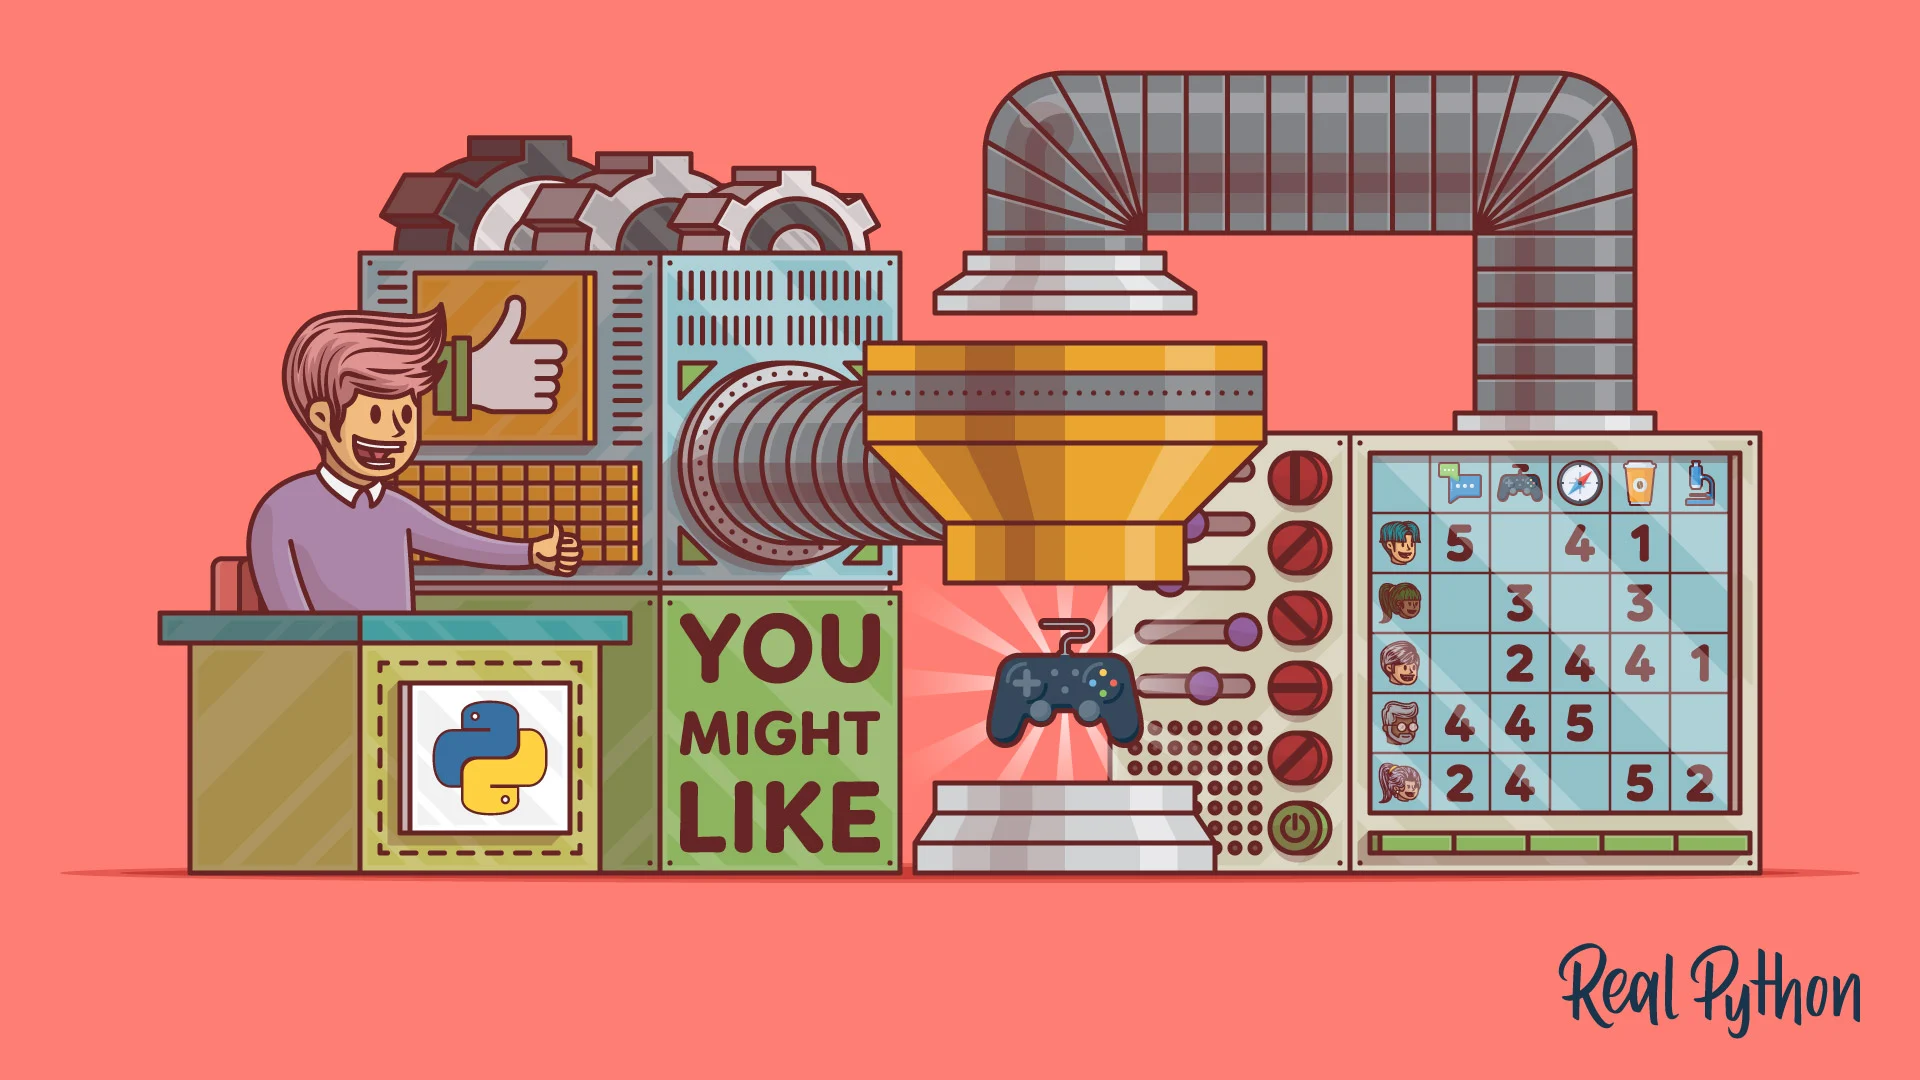

![image.png](images/end.png)


## Buiding Recommendation System with Turicreate


In this notebook we will import Turicreate and use it to

- train two models that can be used for recommending new songs to users 
- compare the performance of the two models


In [45]:
%matplotlib inline
import turicreate as tc
import matplotlib.pyplot as plt


In [46]:
sf = tc.SFrame({'user_id': ["0", "0", "0", "1", "1", "2", "2", "2"],
                       'item_id': ["a", "b", "c", "a", "b", "b", "c", "d"],
                       'rating': [1, 3, 2, 5, 4, 1, 4, 3]})
sf

item_id,rating,user_id
a,1,0
b,3,0
c,2,0
a,5,1
b,4,1
b,1,2
c,4,2
d,3,2


In [47]:
m = tc.recommender.create(sf, target='rating')
recs = m.recommend()
recs

Preparing data set.

Data has 8 observations with 3 users and 4 items.

Data prepared in: 0.004622s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 8 / 8 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | 2.83657                                  |

| 4       | 0.195312          | 2.74513                                  |

| 5       | 0.0976562         | 2.80074                                  |

| 6       | 0.0488281         | 3.00431                                  |

| 7       | 0.0244141         | 3.28335                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 2.74513                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 141us        | 3.89999           | 1.3637                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 628us        | 4.16499           | 1.66421               | 0.195312    |

| 2       | 1.29ms       | 3.17812           | 1.43798               | 0.116134    |

| 3       | 2.021ms      | 2.6823            | 1.24864               | 0.0856819   |

| 4       | 2.607ms      | 2.49669           | 1.15702               | 0.0580668   |

| 5       | 3.279ms      | 2.42692           | 1.15987               | 0.0491185   |

| 10      | 14.955ms     | 2.28822           | 1.08066               | 0.029206    |

| 25      | 36.588ms     | 2.20359           | 1.07144               | 0.0146899   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.79173

Final training RMSE: 1.04408

user_id,item_id,score,rank
0,d,1.2694321870803833,1
1,c,3.9875572323799133,1
1,d,3.1200567483901978,2
2,a,2.483269453048706,1


### The CourseTalk dataset: loading and first look

Loading of the CourseTalk database.

In [48]:
train_file = '../data/ratings.dat'
sf = tc.SFrame.read_csv(train_file, header=False, 
                        delimiter='|', verbose=False)
sf = sf.rename({'X1':'user_id', 'X2':'course_id', 'X3':'rating'})
sf.show()

Materializing SFrame

In order to evaluate the performance of our model, we randomly split the observations in our data set into two partitions: we will use `train_set` when creating our model and `test_set` for evaluating its performance.

In [49]:
sf

user_id,course_id,rating
1,1,5.0
2,1,5.0
3,1,5.0
4,1,5.0
5,1,5.0
6,1,5.0
7,1,5.0
8,1,5.0
9,1,5.0
10,1,5.0


In [50]:
train_set, test_set = sf.random_split(0.8, seed=1)

### Popularity model

Create a model that makes recommendations using item popularity. When no target column is provided, the popularity is determined by the number of observations involving each item. When a target is provided, popularity is computed using the item’s mean target value. When the target column contains ratings, for example, the model computes the mean rating for each item and uses this to rank items for recommendations.

One typically wants to initially create a simple recommendation system that can be used as a baseline and to verify that the rest of the pipeline works as expected. The `recommender` package has several models available for this purpose. For example, we can create a model that predicts songs based on their overall popularity across all users.


In [51]:
popularity_model = tc.popularity_recommender.create(train_set, 'user_id', 'course_id', target = 'rating')

Preparing data set.

Data has 2202 observations with 1651 users and 201 items.

Data prepared in: 0.024186s

2202 observations to process; with 201 unique items.

### Item similarity Model

* [Collaborative filtering](http://en.wikipedia.org/wiki/Collaborative_filtering) methods make predictions for a given user based on the patterns of other users' activities. One common technique is to compare items based on their [Jaccard](http://en.wikipedia.org/wiki/Jaccard_index) similarity.This measurement is a ratio: the number of items they have in common, over the total number of distinct items in both sets.
* We could also have used another slightly more complicated similarity measurement, called [Cosine Similarity](http://en.wikipedia.org/wiki/Cosine_similarity). 

If your data is implicit, i.e., you only observe interactions between users and items, without a rating, then use ItemSimilarityModel with Jaccard similarity.  

If your data is explicit, i.e., the observations include an actual rating given by the user, then you have a wide array of options.  ItemSimilarityModel with cosine or Pearson similarity can incorporate ratings.  In addition, MatrixFactorizationModel, FactorizationModel, as well as LinearRegressionModel all support rating prediction.  

Now data contains three columns: ‘user_id’, ‘item_id’, and ‘rating’.

itemsim_cosine_model = graphlab.recommender.create(data, 
       target=’rating’, 
       method=’item_similarity’, 
       similarity_type=’cosine’)
       
factorization_machine_model = graphlab.recommender.create(data, 
       target=’rating’, 
       method=’factorization_model’)


In the following code block, we compute all the item-item similarities and create an object that can be used for recommendations.

In [52]:
item_sim_model = tc.item_similarity_recommender.create(
    train_set, 'user_id', 'course_id', target = 'rating', 
    similarity_type='cosine')

Preparing data set.

Data has 2202 observations with 1651 users and 201 items.

Data prepared in: 0.021186s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.805ms                        | 60.5       |

| 23.105ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 26.4ms                              | 0                | 0               |

| 32.479ms                            | 100              | 201             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.037491s

### Factorization Recommender Model
Create a FactorizationRecommender that learns latent factors for each user and item and uses them to make rating predictions. This includes both standard matrix factorization as well as factorization machines models (in the situation where side data is available for users and/or items). [link](https://dato.com/products/create/docs/generated/graphlab.recommender.factorization_recommender.create.html#graphlab.recommender.factorization_recommender.create)

In [53]:
factorization_machine_model = tc.recommender.factorization_recommender.create(
    train_set, 'user_id', 'course_id',                                                                    
    target='rating')

Preparing data set.

Data has 2202 observations with 1651 users and 201 items.

Data prepared in: 0.00781s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 2202 / 2202 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | 0.122277                                 |

| 4       | 0.195312          | 0.172024                                 |

| 5       | 0.0976562         | 0.235897                                 |

| 6       | 0.0488281         | 0.338391                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.390625          | 0.122277                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 238us        | 0.891401          | 0.94414               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 285.573ms    | 0.879224          | 0.937667              | 0.390625    |

| 2       | 352.797ms    | 0.511761          | 0.715374              | 0.232267    |

| 3       | 444.885ms    | 0.296781          | 0.544775              | 0.171364    |

| 4       | 535.596ms    | 0.215641          | 0.464371              | 0.138107    |

| 5       | 594.038ms    | 0.156399          | 0.395472              | 0.116824    |

| 10      | 1.10s        | 0.0319218         | 0.178663              | 0.069464    |

| 50      | 4.83s        | 0.000601022       | 0.0244708             | 0.0207746   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.000520035

Final training RMSE: 0.0227559

### Model Evaluation

It's straightforward to use GraphLab to compare models on a small subset of users in the `test_set`. The [precision-recall](http://en.wikipedia.org/wiki/Precision_and_recall) plot that is computed shows the benefits of using the similarity-based model instead of the baseline `popularity_model`: better curves tend toward the upper-right hand corner of the plot. 

The following command finds the top-ranked items for all users in the first 500 rows of `test_set`. The observations in `train_set` are not included in the predicted items.

In [54]:
result = tc.recommender.util.compare_models(
    test_set, [popularity_model, item_sim_model, factorization_machine_model],
    user_sample=.5, skip_set=train_set)

compare_models: using 246 users to estimate model performance
PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |          0.0          |          0.0          |
|   2    | 0.0020325203252032514 | 0.0020325203252032514 |
|   3    | 0.0013550135501355016 | 0.0020325203252032522 |
|   4    | 0.0010162601626016257 | 0.0020325203252032514 |
|   5    | 0.0008130081300813005 | 0.0020325203252032522 |
|   6    | 0.0006775067750677507 |  0.002032520325203251 |
|   7    | 0.0005807200929152149 | 0.0020325203252032522 |
|   8    | 0.0010162601626016261 |  0.003048780487804878 |
|   9    | 0.0009033423667570004 |  0.003048780487804878 |
|   10   | 0.0008130081300813008 |  0.003048780487804878 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall R

Now let's ask the item similarity model for song recommendations on several users. We first create a list of users and create a subset of observations, `users_ratings`, that pertain to these users.

In [41]:
K = 10
users = tc.SArray(sf['user_id'].unique().head(100))
users

dtype: int
Rows: 100
[232, 363, 431, 738, 1860, 732, 187, 1368, 1753, 764, 926, 1180, 1323, 1742, 1685, 1876, 1232, 614, 1573, 786, 1158, 1072, 863, 695, 454, 1211, 1404, 1242, 696, 444, 349, 1883, 499, 354, 573, 1531, 71, 1889, 312, 578, 1556, 1572, 79, 416, 848, 1805, 550, 1644, 1017, 521, 566, 703, 196, 1401, 533, 1054, 398, 1077, 341, 982, 516, 1473, 1982, 1670, 529, 1544, 1920, 1414, 223, 465, 376, 1231, 193, 202, 1128, 1853, 1907, 1331, 966, 810, 1895, 1704, 267, 1615, 350, 979, 69, 138, 1645, 837, 1841, 1801, 853, 803, 405, 1172, 112, 1653, 937, 1429]

Next we use the `recommend()` function to query the model we created for recommendations. The returned object has four columns: `user_id`, `song_id`, the `score` that the algorithm gave this user for this song, and the song's rank (an integer from 0 to K-1). To see this we can grab the top few rows of `recs`:

In [24]:
recs = item_sim_model.recommend(users=users, k=K)
recs.head()

user_id,course_id,score,rank
232,93,0.21959692239761353,1
232,180,0.2127474546432495,2
232,188,0.20187050104141235,3
232,108,0.17809301614761353,4
232,55,0.1753571629524231,5
232,168,0.16715019941329956,6
232,133,0.16673386096954346,7
232,186,0.16153007745742798,8
232,164,0.1601088047027588,9
232,187,0.15785843133926392,10


To learn what songs these ids pertain to, we can merge in metadata about each song.

In [42]:
# Get the meta data of the courses
courses = tc.SFrame.read_csv('../data/cursos.dat', header=False, delimiter='|', verbose=False)
courses =courses.rename({'X1':'course_id', 'X2':'title', 'X3':'avg_rating', 
              'X4':'workload', 'X5':'university', 'X6':'difficulty', 'X7':'provider'})
courses.show()

courses = courses[['course_id', 'title', 'provider']]
results = recs.join(courses, on='course_id', how='inner')

#Populate observed user-course data with course info
userset = frozenset(users)
ix = sf['user_id'].apply(lambda x: x in userset, int)  
user_data = sf[ix]
user_data = user_data.join(courses, on='course_id')[['user_id', 'title', 'provider']]

Materializing SFrame

RuntimeError: Column name course_id does not exist.

In [27]:
# Print out some recommendations 
for i in range(5):
    user = list(users)[i]
    print("User: " + str(i + 1))
    user_obs = user_data[user_data['user_id'] == user].head(K)
    del user_obs['user_id']
    user_recs = results[results['user_id'] == str(user)][['title', 'provider']]

    print("We were told that the user liked these courses: ")
    print (user_obs.head(K))

    print ("We recommend these other courses:")
    print (user_recs.head(K))

    print ("")

User: 1
We were told that the user liked these courses: 
+-------------------------------+----------+
|             title             | provider |
+-------------------------------+----------+
| An Introduction to Interac... | coursera |
+-------------------------------+----------+
[1 rows x 2 columns]

We recommend these other courses:
+-------+----------+
| title | provider |
+-------+----------+
+-------+----------+
[0 rows x 2 columns]


User: 2
We were told that the user liked these courses: 
+-------------------------------+----------+
|             title             | provider |
+-------------------------------+----------+
| An Introduction to Interac... | coursera |
+-------------------------------+----------+
[1 rows x 2 columns]

We recommend these other courses:
+-------+----------+
| title | provider |
+-------+----------+
+-------+----------+
[0 rows x 2 columns]


User: 3
We were told that the user liked these courses: 
+-------------------------------+----------+
|       

## Readings
- (Looking for more details about the modules and functions? Check out the <a href="https://dato.com/products/create/docs/">API docs</a>.)
- Toby Segaran, 2007, Programming Collective Intelligence. O'Reilly. Chapter 2 Making Recommendations
    - programming-collective-intelligence-code/blob/master/chapter2/recommendations.py
- 项亮 2012 推荐系统实践 人民邮电出版社